## Creating the Dataset

In [1]:
%ls ../../../data

amazonreviews/  CIFAR100/      hist-cancer/       MNIST/         voc2012/
AMD/            coco/          hmdb51_jpg/        QuickDraw/     VOiCES/
celeba/         FashionMNIST/  hmdb51_org/        stl10_binary/
cifar10/        hc18/          hymenoptera_data/  UTKface/


In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

# path to store/load data
#path2data="../Chapter03/data/"
path2data="../../../data/"
os.makedirs(path2data, exist_ok= True)
    

h, w = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
transform= transforms.Compose([
           transforms.Resize((h,w)),
           transforms.CenterCrop((h,w)),
           transforms.ToTensor(),
           transforms.Normalize(mean, std)])
    
train_ds=datasets.STL10(path2data, split='train', 
                        download=False,
                        transform=transform)
print(len(train_ds))

5000


In [3]:
import torch
for x, _ in train_ds:
    print(x.shape, torch.min(x), torch.max(x))
    break

torch.Size([3, 64, 64]) tensor(-0.8980) tensor(0.9529)


In [4]:
import torch

for x,y in train_ds:
    print(x.shape,y)
    break

torch.Size([3, 64, 64]) 1


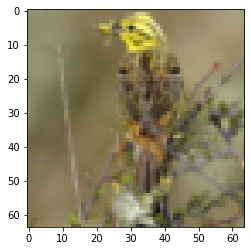

In [5]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

plt.imshow(to_pil_image(0.5*x+0.5))

In [6]:
import torch

batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True)

In [7]:
for x,y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 64, 64]) torch.Size([32])


## Defining Generator

In [8]:
from torch import nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        nz = params["nz"]
        ngf = params["ngf"]
        noc = params["noc"]
        self.dconv1 = nn.ConvTranspose2d( nz, ngf * 8, kernel_size=4,
                                         stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        self.dconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.dconv3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.dconv4 = nn.ConvTranspose2d( ngf * 2, ngf, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.dconv5 = nn.ConvTranspose2d( ngf, noc, kernel_size=4, 
                                         stride=2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))            
        x = F.relu(self.bn3(self.dconv3(x)))        
        x = F.relu(self.bn4(self.dconv4(x)))    
        out = torch.tanh(self.dconv5(x))
        return out

In [9]:
params_gen = {
        "nz": 100,
        "ngf": 64,
        "noc": 3,
        }
model_gen = Generator(params_gen)
device = torch.device("cuda:1")
# check cuda memory and set the device number?
model_gen.to(device)
print(model_gen)

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [10]:
with torch.no_grad():
    y= model_gen(torch.zeros(1,100,1,1, device=device))
print(y.shape)    

torch.Size([1, 3, 64, 64])


## Defining Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super(Discriminator, self).__init__()
        nic= params["nic"]
        ndf = params["ndf"]
        self.conv1 = nn.Conv2d(nic, ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)            
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace = True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace = True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace = True)        
        
        out = torch.sigmoid(self.conv5(x))
        return out.view(-1)

In [12]:
params_dis = {
    "nic": 3,
    "ndf": 64}
model_dis = Discriminator(params_dis)
model_dis.to(device)
print(model_dis)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [13]:
with torch.no_grad():
    y= model_dis(torch.zeros(1,3,h,w, device=device))
print(y.shape)    

torch.Size([1])


In [14]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [15]:
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

## Defining Loss, Optimizer

In [16]:
loss_func = nn.BCELoss()

In [17]:
from torch import optim

lr = 2e-4 
beta1 = 0.5
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, 0.999))

In [18]:
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [ ]:
real_label = 1
fake_label = 0
nz = params_gen["nz"]
num_epochs = 1000


loss_history={"gen": [],
              "dis": []}

batch_count = 0
for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.size(0)
        model_dis.zero_grad()
        xb = xb.to(device)
        #yb = torch.full((ba_si,), real_label, device=device)
        # ERROR MESSAGE : expected float but long
        yb = torch.full((ba_si,), real_label, device=device).float()
        out_dis = model_dis(xb)
        loss_r = loss_func(out_dis, yb)
        loss_r.backward()

        noise = torch.randn(ba_si, nz, 1, 1, device=device)
        out_gen = model_gen(noise)
        out_dis = model_dis(out_gen.detach())
        yb.fill_(fake_label)    
        loss_f = loss_func(out_dis, yb)
        loss_f.backward()
        loss_dis = loss_r + loss_f  
        opt_dis.step()   

        model_gen.zero_grad()
        yb.fill_(real_label)  
        out_dis = model_dis(out_gen)
        loss_gen = loss_func(out_dis, yb)
        loss_gen.backward()
        opt_gen.step()

        loss_history["gen"].append(loss_gen.item())
        loss_history["dis"].append(loss_dis.item())
        batch_count += 1
        if batch_count % 100 == 0:
            print(epoch, loss_gen.item(),loss_dis.item())
        

0 4.5208964347839355 0.060893911868333817
1 5.643194198608398 0.11870373785495758
1 6.1786298751831055 0.14720506966114044
2 5.603593826293945 0.01867794618010521
3 5.138758659362793 0.05480406433343887
3 3.179868221282959 0.16925860941410065
4 13.94198989868164 1.1245719194412231
5 6.059863090515137 0.15431463718414307
5 4.863922119140625 0.0981982946395874
6 5.739299774169922 0.14751625061035156
7 5.121713638305664 0.07492499053478241
7 4.7835187911987305 0.04217460751533508
8 5.363590240478516 0.09963566809892654
8 4.422281265258789 0.20413632690906525
9 5.048807144165039 0.07837767899036407
10 5.194312572479248 0.05579362437129021
10 5.366819381713867 0.053459327667951584
11 5.9719648361206055 0.03709141165018082
12 8.552879333496094 1.6504831314086914
12 4.872987747192383 0.1696682572364807
13 4.428747177124023 0.19965648651123047
14 5.949540138244629 0.14410187304019928
14 4.875140190124512 0.04321136325597763
15 4.978357315063477 0.05735275149345398
15 5.210136413574219 0.059008

127 6.493101119995117 0.025525348260998726
128 7.745081901550293 0.07777771353721619
128 2.450251579284668 1.3920387029647827
129 5.674014091491699 0.2606014013290405
129 6.947979927062988 0.12532910704612732
130 5.791055679321289 0.06637441366910934
131 7.913840293884277 0.04728231579065323
131 6.298303604125977 0.021939096972346306
132 9.611629486083984 0.14538313448429108
133 6.827637672424316 0.019438153132796288
133 6.134892463684082 0.07395103573799133
134 7.403497695922852 0.012438327074050903
135 8.06899642944336 0.006680866703391075
135 10.307811737060547 0.0609300322830677
136 8.04863166809082 0.0079256696626544
136 7.005433082580566 0.04813686013221741
137 7.5524187088012695 0.010635260492563248
138 10.507465362548828 0.03399146348237991
138 6.554611682891846 0.012385528534650803
139 7.7765960693359375 0.03852018713951111
140 8.148642539978027 0.0728205144405365
140 10.355508804321289 0.23868177831172943
141 5.669286727905273 0.040898751467466354
142 7.788272380828857 0.0051

250 7.372912406921387 0.01890641264617443
250 8.684879302978516 0.02145884931087494
251 12.250940322875977 0.00480410922318697
252 12.507804870605469 0.02226320281624794
252 9.099311828613281 0.04357424005866051
253 12.236261367797852 0.006426181178539991
254 8.861719131469727 0.003360068891197443
254 7.108028411865234 0.05535445362329483
255 10.793486595153809 0.0067297532223165035
256 7.834939002990723 0.10124600678682327
256 15.219656944274902 0.10415752977132797
257 8.093749046325684 0.00586566561833024
257 8.72659683227539 0.014892606995999813
258 15.541093826293945 0.06821023672819138
259 15.626568794250488 0.024530667811632156
259 9.352384567260742 0.00743370596319437
260 8.907745361328125 0.012569095939397812
261 8.749579429626465 0.006983187980949879
261 9.95401382446289 0.023111555725336075
262 9.422294616699219 0.02255062945187092
263 23.71088218688965 0.41845428943634033
263 10.031283378601074 0.09345794469118118
264 9.546157836914062 0.007825828157365322
264 6.954277038574

371 10.38985824584961 0.005072296597063541
372 8.459758758544922 0.014740657061338425
373 8.919418334960938 0.028063075616955757
373 8.866130828857422 0.014173985458910465
374 39.918731689453125 1.5834280252456665
375 23.974308013916016 0.003954353742301464
375 13.831676483154297 0.010771367698907852
376 9.21560001373291 0.014988800510764122
377 11.529319763183594 0.0022711693309247494
377 18.062273025512695 0.00990425143390894
378 12.62657356262207 0.008463269099593163
378 11.022029876708984 0.03577412664890289
379 13.123281478881836 0.0005092918290756643
380 9.023736953735352 0.0551556833088398
380 11.731050491333008 0.013536076992750168
381 9.202260971069336 0.0031256340444087982
382 8.690925598144531 0.026309091597795486
382 21.78957748413086 0.0240184236317873
383 9.129291534423828 0.003440428525209427
384 9.283665657043457 0.0049990322440862656
384 17.209287643432617 0.03293118625879288
385 9.470745086669922 0.005370225291699171
385 10.000255584716797 0.014984605833888054
386 8.6

492 11.216392517089844 0.002703513018786907
492 15.608001708984375 0.022273750975728035
493 18.607145309448242 0.0007231902563944459
494 12.408815383911133 0.02988416887819767
494 13.994556427001953 0.026754043996334076
495 9.729570388793945 0.01671862229704857
496 17.615480422973633 0.004885516129434109
496 11.323113441467285 0.0015170971164479852
497 10.379999160766602 0.015100251883268356
498 9.282246589660645 0.014133425429463387
498 15.194026947021484 0.011717232875525951
499 9.099525451660156 0.00502643920481205
499 13.978886604309082 0.0002718331234063953
500 14.350198745727539 0.02009538933634758
501 13.551498413085938 0.021398907527327538
501 9.098732948303223 0.005274566356092691
502 14.250146865844727 0.0004115519695915282
503 9.771890640258789 0.007915244437754154
503 9.993587493896484 0.038035135716199875
504 19.559898376464844 0.011586710810661316
505 9.40865707397461 0.030206095427274704
505 17.7851619720459 0.017046228051185608
506 7.72608757019043 0.026605769991874695


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss Progress")
plt.plot(loss_history["gen"],label="Gen. Loss")
plt.plot(loss_history["dis"],label="Dis. Loss")
plt.xlabel("batch count")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# store models
import os
path2models = "./models/"
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, "weights_gen_128.pt")
path2weights_dis = os.path.join(path2models, "weights_dis_128.pt")

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

## Deploying Generator

In [ ]:
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)
model_gen.eval()

In [ ]:
import numpy as np

with torch.no_grad():
    fixed_noise = torch.randn(16, nz, 1, 1, device=device)
    print(fixed_noise.shape)
    img_fake = model_gen(fixed_noise).detach().cpu()    
print(img_fake.shape)

plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5))
    plt.axis("off")
    